# Text Recognition Benchmarking

## Local Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports

In [2]:
import pandas as pd
import xml.etree.ElementTree as ET
import html
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import fastwer
import re

from typing import Union
from pathlib import Path
from tqdm import tqdm

import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

## Getting the Data
The tests are run on the IAM words dataset or the IAM lines dataset. <br>
Choose what to test on by setting words or lines to true.


In [3]:
words = True
lines = False

### Set Path to IAM folder

Inside you need to have the words and/or lines and xml folder.

IAM/words <br>
IAM/lines <br>
IAM/xml

In [4]:
from data import IAM

iam = IAM()

### Load word images (paths, img_id and targets) 

( if you want to test on words )

In [5]:
if words:
    words_data = iam.get_words(skip_bad_segmentation=True)
    words_data.head()

In [6]:
if words:
    print("Total number of words: ", len(words_data))

Total number of words:  96456


#### Get the Aachen Test split

In [12]:
if words:
    file = open("../data/IAM/aachen_splits/test.uttlist")
    test_ids = file.read().split("\n")
    words_test = words_data[words_data['img_id'].isin(test_ids)]

    print("Number of words in test set: ", len(words_test))

Number of words in test set:  20310


#### Convert all to lowercase

In [13]:
if words:
    words_test_lower = words_test.copy()
    words_test_lower['target'] = [x.lower() for x in words_test_lower['target']]

    words_test_lower.head()

#### Remove punctuation symbols  [.,:;\&+-?!"()*/']
Images that only contains punctuation symbols are removed from the dataset.

In [14]:
if words:
    words_test_filtered = words_test_lower.copy()

    # Remove symbols from transcript. Removes everything that isn't a alphanumeric character.
    words_test_filtered['target'] = [re.sub(r'[^a-z0-9]', '', x) for x in words_test_filtered['target']]

    # Remove images that now has empty target.
    orig_data_size = len(words_test_filtered)
    words_test_filtered = words_test_filtered[words_test_filtered['target'] != ""]
    new_data_size = len(words_test_filtered)
    
    print("{} images removed containing only punctutation symbols.".format(orig_data_size - new_data_size))
    print("New test size: ", new_data_size)
    print(words_test_filtered.head())
    
    # Let's call this final set simply words_test
    words_test = words_test_filtered

2558 images removed containing only punctutation symbols.
New test size:  17752
                                                img_path   img_id       target
26266  C:\Users\Vihoa\git\orthographer\data\IAM\words...  c04-110  assuredness
26268  C:\Users\Vihoa\git\orthographer\data\IAM\words...  c04-110        bella
26269  C:\Users\Vihoa\git\orthographer\data\IAM\words...  c04-110        bella
26270  C:\Users\Vihoa\git\orthographer\data\IAM\words...  c04-110        marie
26273  C:\Users\Vihoa\git\orthographer\data\IAM\words...  c04-110   parlophone


### Get lines images 

(if you want to test on lines)

In [ ]:
if lines:
    lines_data = iam.get_lines(skip_bad_segmentation=True)
    print(lines_data.head())

In [ ]:
if lines:
    print("Total number of lines: ", len(lines_data))
    print("Total number of words: ", sum([len(x.split(" ")) for x in list(lines_data['target'])]))

#### Get the Aachen test split

In [ ]:
if lines:
    file = open("../data/IAM/aachen_splits/test.uttlist")
    test_ids = file.read().split("\n")
    lines_test = lines_data[lines_data['img_id'].isin(test_ids)]

    print("Number of lines in test set: ", len(lines_test))
    print("Number of words in test set: ", sum([len(x.split(" ")) for x in list(lines_test['target'])]))

#### Convert all to lower case

In [ ]:
if lines:
    lines_test_lower = lines_test.copy()
    
    lines_test_lower['target'] = [x.lower() for x in lines_test_lower['target']]

In [ ]:
if lines:
    lines_test_filtered = lines_test_lower.copy()

    # Remove symbols from transcript. Removes everything that isn't a alphanumeric character.
    lines_test_filtered['target'] = [re.sub(r'[^a-z 0-9]', '', x) for x in lines_test_filtered['target']]

    # Remove images that now has empty target.
    orig_data_size = len(lines_test_filtered)
    lines_test_filtered = lines_test_filtered[lines_test_filtered['target'] != ""]
    new_data_size = len(lines_test_filtered)
    
    print(lines_test_filtered.head())
    
    # Let's call this final set simply lines_test
    lines_test = lines_test_filtered

### Function to fetch a specific img and it's target

OBS, do not use cv.imshow to display images in jupyter notebook as it will probably crash. Use pyplot instead.

In [16]:
def getImage(dataframe, idx):
    data = dataframe.iloc[idx]
    img = cv.imread(data["img_path"])
    
    assert isinstance(img, np.ndarray), (
        f"Error: image at path {data['img_path']} is not properly loaded. "
        f"Is there something wrong with this image?"
    )
    
    return img, data["target"]

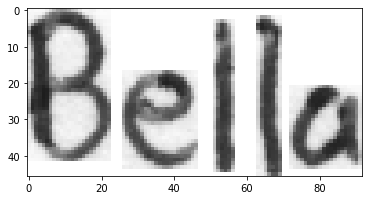

Target:  bella


In [17]:
if words:
    ex_img, ex_target = getImage(words_test, 1)

    plt.imshow(cv.cvtColor(ex_img, cv.COLOR_BGR2RGB))
    plt.show()

    print("Target: ", ex_target)
    
if lines:
    ex_img, ex_target = getImage(lines_test, 1)

    plt.imshow(cv.cvtColor(ex_img, cv.COLOR_BGR2RGB))
    plt.show()

    print("Target: ", ex_target)

## Model Benchmark

In [10]:
def run_benchmark(data_set, model):
    size = len(data_set)
    
    tickmeter = cv.TickMeter()
    
    result = {
        "img_path": [], 
        "target": [], 
        "pred": [], 
        "cer": [], 
        "wer": [], 
        "inf_time": []
    }
    
    for i in tqdm(range(size)):
        # If file is corrupt, error will be raised.
        try:    
            img, target = getImage(data_set, i)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            tickmeter.start()
            pred, conf = model(img)
            tickmeter.stop()
            
            # Make sure pred are filtered the same way as targets.
            pred = pred.lower()
            pred = re.sub(r'[^a-z 0-9]', '', pred)
            
        except Exception as e:
            print("Problem with index: ", i)
            print("Exception: ", e)
            continue
        
        cer = fastwer.score_sent(pred, target, char_level=True)
        wer = fastwer.score_sent(pred, target)
        
        inf_time = tickmeter.getTimeMilli()
        tickmeter.reset()
        
        # Fill in result
        result['img_path'].append(data_set.iloc[i]['img_path'])
        result['target'].append(target.lower())
        result['pred'].append(pred)
        result['cer'].append(cer)
        result['wer'].append(wer)
        result['inf_time'].append(inf_time)
    
    result = pd.DataFrame(result)
    
    # Make sure cer and wer < 100. (eg if two words were predicted when there is one, wer = 200 %)  
    result.loc[result["cer"] > 100, "cer"] = 100
    result.loc[result["wer"] > 100, "wer"] = 100
    
    return result

##########################################################################################################
def calc_cer_wer_inf(result):
    cer = result['cer'].mean()
    wer = result['wer'].mean()
    inf_time = result['inf_time'].mean()
    
    print("CER: %.2f, WER: %.2f, Inf: %.2f" % (cer, wer, inf_time))
    
    return cer, wer, inf_time

# Model Evaluation

In [ ]:
models_path = "../models/TR/"

## ONNX Models Evaluation

### DenseNet_CTC

In [ ]:
from onnx_model import ONNXModel

denseNet_path = models_path + "DenseNet_CTC.onnx"

denseNet = ONNXModel(model_path=denseNet_path)

result_dense = run_benchmark(words_test, denseNet)

cer_dense, wer_dense, inf_dense = calc_cer_wer_inf(result_dense)

In [ ]:
result_dense.head()

### ResNet_CTC

In [ ]:
from onnx_model import ONNXModel

resNet_path = models_path + "ResNet_CTC.onnx"

resNet = ONNXModel(model_path=resNet_path)

result_res = run_benchmark(words_test, resNet)

cer_res, wer_res, inf_res = calc_cer_wer_inf(result_res)

In [ ]:
result_res.head()

### CRNN_VGG_BiLSTM_CTC

In [ ]:
from onnx_model import ONNXModel

crn_path = models_path + "CRNN_VGG_BiLSTM_CTC.onnx"

crnNet = ONNXModel(model_path=crn_path)

result_crn = run_benchmark(words_test, crnNet)

cer_crn, wer_crn, inf_crn = calc_cer_wer_inf(result_crn)

In [ ]:
result_crn.head()

## Deep Text Recognition Benchmark Models

### OrthoNet

OBS. Edit model_builder.py to configure the model for evaluation.

In [ ]:
import dtrb.model_builder
from dtrb.model_builder import create_dtrb_model

orthoNet = create_dtrb_model()

result_ortho = run_benchmark(words_test, orthoNet)

cer_ortho, wer_ortho, inf_ortho = calc_cer_wer_inf(result_ortho)

result_ortho.head()

## TrOCR

In [22]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TrOCR:
    def __init__(self, processor, model):
        self.processor = processor
        self.model = model
    ####################################################################################################
    def __call__(self, image):        
        """Runs text recognition on each image in concat_images. Lengths is the number of words in each image."""
        image = cv.cvtColor(image, cv.COLOR_GRAY2RGB) # frame to RGB

        # Run recognition.
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)
        generated_ids = self.model.generate(pixel_values)
        text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return text, 0

cuda


### Small

In [20]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten',  pad_token_id=processor.tokenizer.pad_token_id)

trocr = TrOCR(processor, model)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Words Dataset

In [21]:
if words:
    result_words_trocr_small = run_benchmark(words_test, trocr)
    cer_words_trocr_small, wer_words_trocr_small, inf_words_trocr_small = calc_cer_wer_inf(result_words_trocr_small)
    result_words_trocr_small.head()

  0%|                                                                               | 14/17752 [00:00<06:42, 44.12it/s]

Problem with index:  0
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  1
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  2
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  3
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  4
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  5
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  6
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  7
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be t

  0%|▏                                                                              | 35/17752 [00:00<03:57, 74.73it/s]

Problem with index:  22
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  23
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  24
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  25
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  26
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  27
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  28
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  29
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) sho

  0%|▎                                                                              | 58/17752 [00:00<03:09, 93.56it/s]

Problem with index:  42
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  43
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  44
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  45
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  46
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  47
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  48
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  49
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) sho

  0%|▎                                                                             | 82/17752 [00:01<02:49, 104.11it/s]

Problem with index:  63
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  64
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  65
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  66
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  67
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  68
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  69
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  70
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) sho

  1%|▍                                                                            | 106/17752 [00:01<02:42, 108.32it/s]

Problem with index:  84
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  85
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  86
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  87
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  88
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  89
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  90
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  91
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) sho

  1%|▌                                                                            | 118/17752 [00:01<02:43, 108.09it/s]

Problem with index:  106
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  107
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  108
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  109
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  110
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  111
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  112
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  113
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|▌                                                                             | 140/17752 [00:01<03:00, 97.84it/s]

Problem with index:  127
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  128
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  129
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  130
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  131
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  132
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  133
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  134
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|▋                                                                             | 161/17752 [00:01<03:03, 96.06it/s]

Problem with index:  144
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  145
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  146
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  147
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  148
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  149
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  150
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  151
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|▊                                                                            | 173/17752 [00:01<02:54, 100.60it/s]

Problem with index:  162
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  163
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  164
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  165
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  166
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  167
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  168
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  169
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|▊                                                                            | 197/17752 [00:02<02:42, 107.80it/s]

Problem with index:  183
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  184
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  185
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  186
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  187
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  188
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  189
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  190
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|▉                                                                            | 222/17752 [00:02<02:33, 114.00it/s]

Problem with index:  206
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  207
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  208
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  209
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  210
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  211
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  212
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  213
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|█                                                                            | 246/17752 [00:02<02:36, 111.96it/s]

Problem with index:  228
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  229
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  230
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  231
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  232
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  233
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  234
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  235
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  1%|█                                                                            | 258/17752 [00:02<02:46, 105.12it/s]

Problem with index:  248
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  249
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  250
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  251
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  252
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  253
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  254
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  255
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▏                                                                           | 280/17752 [00:02<02:47, 104.34it/s]

Problem with index:  266
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  267
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  268
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  269
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  270
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  271
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  272
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  273
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▎                                                                           | 302/17752 [00:03<02:46, 105.01it/s]

Problem with index:  287
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  288
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  289
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  290
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  291
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  292
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  293
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  294
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▍                                                                           | 327/17752 [00:03<02:37, 110.41it/s]

Problem with index:  307
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  308
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  309
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  310
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  311
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  312
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  313
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  314
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▍                                                                           | 339/17752 [00:03<02:38, 109.73it/s]

Problem with index:  329
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  330
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  331
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  332
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  333
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  334
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  335
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  336
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▌                                                                           | 363/17752 [00:03<02:37, 110.19it/s]

Problem with index:  350
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  351
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  352
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  353
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  354
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  355
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  356
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  357
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▋                                                                           | 387/17752 [00:03<02:39, 109.14it/s]

Problem with index:  370
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  371
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  372
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  373
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  374
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  375
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  376
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  377
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▋                                                                            | 398/17752 [00:04<02:54, 99.23it/s]

Problem with index:  390
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  391
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  392
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  393
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  394
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  395
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  396
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  397
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  2%|█▊                                                                           | 422/17752 [00:04<02:41, 107.01it/s]

Problem with index:  409
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  410
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  411
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  412
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  413
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  414
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  415
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  416
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  3%|█▉                                                                           | 445/17752 [00:04<02:46, 103.83it/s]

Problem with index:  431
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  432
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  433
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  434
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  435
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  436
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  437
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  438
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  3%|██                                                                            | 466/17752 [00:04<02:57, 97.64it/s]

Problem with index:  448
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  449
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  450
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  451
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  452
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  453
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  454
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  455
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  3%|██                                                                            | 476/17752 [00:04<02:58, 96.83it/s]

Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  467
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  468
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  469
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  470
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  471
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  472
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  473
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with 

  3%|██▏                                                                           | 498/17752 [00:04<02:54, 98.91it/s]

Problem with index:  486
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  487
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  488
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  489
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  490
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  491
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  492
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  493
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

  3%|██▎                                                                          | 525/17752 [00:05<02:51, 100.44it/s]

Problem with index:  508
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  509
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  510
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  511
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  512
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  513
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  514
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Problem with index:  515
Exception:  Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTen

KeyboardInterrupt: 

#### Lines Dataset

In [ ]:
if lines:
    result_lines_trocr_small = run_benchmark(lines_test, trocr)
    cer_lines_trocr_small, wer_lines_trocr_small, inf_lines_trocr_small = calc_cer_wer_inf(result_lines_trocr_small)
    result_words_trocr_small.head()

### Base

In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten', pad_token_id=processor.tokenizer.pad_token_id)

trocr = TrOCR(processor, model)

#### Words

In [ ]:
if words:
    result_words_trocr_base = run_benchmark(words_test, trocr)
    cer_words_trocr_base, wer_words_trocr_base, inf_words_trocr_base = calc_cer_wer_inf(result_words_trocr_base)
    result_words_trocr_base.head()

In [ ]:
result_words_trocr_base.to_csv('result_words_trocr_base_22-05-29_sep.csv',  sep =';')

#### Lines

In [ ]:
if lines:
    result_lines_trocr_base = run_benchmark(lines_test, trocr)
    cer_lines_trocr_base, wer_lines_trocr_base, inf_lines_trocr_base = calc_cer_wer_inf(result_lines_trocr_base)
    result_lines_trocr_base.head()

In [ ]:
result_lines_trocr_base.to_csv('result_lines_trocr_base_22-05-29_sep.csv',  sep =';')

### Large

In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten', pad_token_id=processor.tokenizer.pad_token_id)

trocr = TrOCR(processor, model)

#### Words

In [ ]:
if words:
    result_words_trocr_large = run_benchmark(words_test, trocr)
    cer_words_trocr_large, wer_words_trocr_large, inf_words_trocr_large = calc_cer_wer_inf(result_words_trocr_large)
    result_words_trocr_large.head()

In [ ]:
result_words_trocr_large.to_csv('result_words_trocr_large_22-05-25_sep.csv',  sep =';')

#### Lines

In [ ]:
if lines:
    result_lines_trocr_large = run_benchmark(lines_test, trocr)
    cer_lines_trocr_large, wer_lines_trocr_large, inf_lines_trocr_large = calc_cer_wer_inf(result_lines_trocr_large)
    result_words_trocr_base.head()